## PyBEAM Tutorial 6: Base model with weibull decision thresholds.

In this script, we demonstrate how to build a model with a weibull decision threhsold. This threshold is unique in how it samples parameters. Instead of sampling its parameters directly, two parameters, lambda (the scale parameter) and kappa (the shape parameter) are sampled in logspace. The explanation for this is discussed in the PyBEAM paper; here, we show how to use this.

First, as before, import PyBEAM's default module.


In [1]:
# import PyBEAM's default module
import pybeam.default as pbd

# also import numpy to take a log10
import numpy as np


We next define the model we intend to use. As before, we start with the base model type. Then, since we desire weibull decision thresholds, we change the threshold value from 'fixed' to 'weibull'. Per parse_model, this adds three parameters to the model for the moving threshold: lamb, kappa, and c. Discussed in greater detail in the publication, these are the shape, scale, and collpase parameters.


In [2]:
# define model
model = {'type' : 'base',    # model type ('base' or 'ugm'). Six model keys needed with value 'base'.
        'sigma' : 1.0,       # sets sigma, the scaling parameter
    'threshold' : 'weibull', # sets threshold type (fixed, linear, exponential, or weibull)
      'leakage' : False,     # if True, drift rate has leaky integration
        'delay' : False,     # if True, decision threshold motion is delayed (only for non-fixed thresholds)
'contamination' : False}     # if True, uniform contamination added ot model

# outputs the parameters used by your model
pbd.parse_model(model)


['t_nd', 'w', 'mu', 'a', 'lamb', 'kappa', 'c']

We now simulate data from the model. As discussed above, we use the log10 of the 'lamb' and 'kappa' instead of the parameter itself. So, we choose lamb = 1.0 and kappa = 3.0, but input the log10 of these values into our parameter array phi.


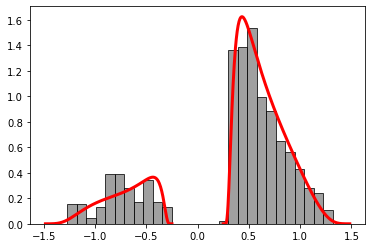

In [9]:
# parameters for synthetic data set 0
phi = {'t_nd' : 0.25,          # non-decision time
          'w' : 0.5,           # relative start point
         'mu' : 1.0,           # drift rate
          'a' : 0.75,          # decision threshold location
       'lamb' : np.log10(1.0), # log10 of weibull shape parameter
      'kappa' : np.log10(3.0), # log10 of weibull scale parameter
          'c' : -1.0}          # weibull collapse parameter

# generate synthetic data
rt = pbd.simulate_model(N_sims = 500,   # number of data points to simulate
                         model = model, # dictionary containing model information 
                           phi = phi)   # parameters used to simulate data

# plot synthetic data and model rt distributions
pbd.plot_rt(model = model, # dictionary containing model information 
              phi = phi,   # parameters used for model rt distribution
               rt = rt);   # dictionary of simulated rt data


We now proceed as in Tutorial 3. We define our bank of priors, conditions, and run the inference program. Note that, as discussed above, we sample from the log10 of the parameter for both tau and kappa. So, the uniform prior with range -1.0 to 2.0 has actual parameter values of 10^(-1.0) to 10^(2.0).

*(Note): For numerical stability, the threhsold is never allowed to fully collapse to zero. If it reaches 1.0e-4 (or -1.0e-4 for the lower threshold), it remains at 1.0e-4.*


In [10]:
# define model priors
p = {'pt_nd' : 'Uniform("t_nd", lower = 0.0, upper = 0.75)',
        'pw' : 'Uniform("w", lower = 0.3, upper = 0.7)',
       'pmu' : 'Uniform("mu", lower = -5.0, upper = 5.0)', 
        'pa' : 'Uniform("a", lower = 0.25, upper = 1.5)',
     'plamb' : 'Uniform("lamb", lower = -1.0, upper = 2.0)',
    'pkappa' : 'Uniform("kappa", lower = -1.0, upper = 2.0)',
        'pc' : -1.0}

# define model condition
c = {'rt' : rt,
   't_nd' : 'pt_nd',
      'w' : 'pw',
     'mu' : 'pmu',
      'a' : 'pa',
   'lamb' : 'plamb',
  'kappa' : 'pkappa',
      'c' : 'pc'}

# load conditions into dictionary
cond = {0 : c}

# run parameter inference
trace = pbd.inference(model = model,
                     priors = p,
                 conditions = cond,
                    samples = 25000,
                     chains = 3,
                      cores = 3,
                  file_name = 'tutorial6')


Multiprocess sampling (3 chains in 3 jobs)
DEMetropolisZ: [kappa, lamb, a, mu, w, t_nd]


Sampling 3 chains for 0 tune and 25_000 draw iterations (0 + 75_000 draws total) took 42 seconds.


We now plot our posteriors. Both 'lamb' and 'kappa' are plotted in log10 space. So, the actual parameter value is 10^(posterior value).


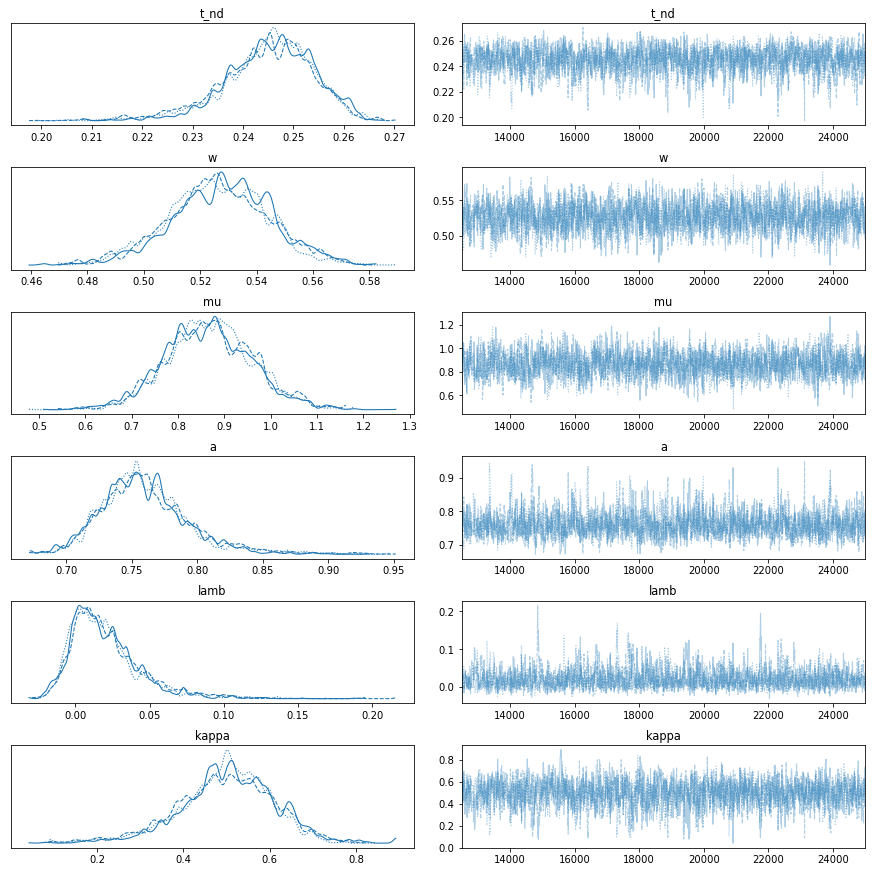

In [11]:
# plot posteriors
pbd.plot_trace(file_name = 'tutorial6', burnin = 12500);


In [12]:
# summary of posteriors
pbd.summary(file_name = 'tutorial6', burnin = 12500)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t_nd,0.245,0.009,0.229,0.262,0.000,0.000,1150.0,1513.0,1.0
w,0.527,0.018,0.492,0.559,0.000,0.000,1375.0,2028.0,1.0
mu,0.868,0.094,0.706,1.060,0.003,0.002,1261.0,1758.0,1.0
a,0.760,0.034,0.702,0.826,0.001,0.001,1113.0,1508.0,1.0
lamb,0.020,0.024,-0.018,0.064,0.001,0.001,1277.0,1021.0,1.0
kappa,0.499,0.109,0.296,0.705,0.003,0.002,1204.0,1545.0,1.0
